In [ ]:
# Import libraries
from scipy.integrate import odeint

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [3]:
# Numerical solution of the SIR model
def sir_model(beta, gamma, S0, I0, R0, max_time):
    # A grid of time points
    t = np.linspace(0, max_time, max_time*100+1)

    # The SIR model differential equations
    def deriv(y, _, beta, gamma):
        S, I, R = y
        N = S + I + R

        dSdt = - beta*S*I/N
        dIdt = beta*S*I/N - gamma*I
        dRdt = gamma*I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid
    S, I, R = odeint(deriv, y0, t, (beta, gamma)).T

    # Put the data into a DataFrame with time as the index
    df = pd.DataFrame({'S': S, 'I': I, 'R': R}, index=t)
    df.index.name = 'time'

    return df

# Function to process simulation data
def processing_simulation_data(path):
    # Read the simulation data from the CSV file
    raw_simulation_df = pd.read_csv(path, index_col=[0,1,2])
    raw_simulation_df.sort_index(inplace=True)

    # Calculate the mean and standard deviation over the 'simulation' level
    mean_simulation_df = raw_simulation_df.groupby(['spread_status','time']).mean()
    std_simulation_df = raw_simulation_df.groupby(['spread_status','time']).std()
    mean_simulation_df.columns = pd.MultiIndex.from_product([['mean'], mean_simulation_df.columns])
    std_simulation_df.columns = pd.MultiIndex.from_product([['std'], std_simulation_df.columns])
    simulation_df = pd.concat([mean_simulation_df, std_simulation_df], axis=1)

    # Group by the 'simulation' level and get the first value of 'spread_status' for each simulation
    unique_spread_status = raw_simulation_df.groupby(level='simulation').apply(lambda df: df.index.get_level_values('spread_status')[0])

    # Count the number of True and False
    spread_status_counts = unique_spread_status.value_counts()

    return simulation_df, spread_status_counts

## SIR model

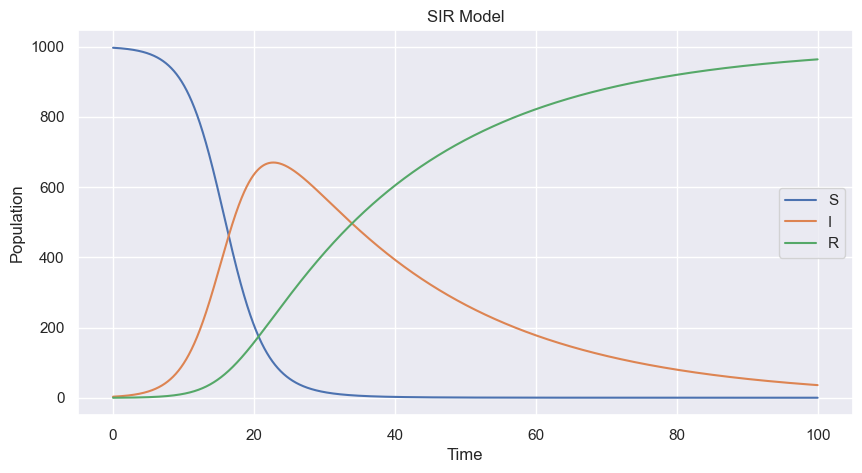

In [4]:
# Initial conditions and parameters for the SIR model
S0, I0, R0 = 997, 3, 0
beta, gamma, total_time = 0.4, 0.04, 100

# Numerical solution of the SIR model
model_df = sir_model(beta, gamma, S0, I0, R0, total_time)

# Plotting the SIR model
plt.figure(figsize=(10, 5))
sns.lineplot(data=model_df, dashes=False)
plt.title("SIR Model")
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

## SIR Network Disease Spread Simulation

File: SIR_ER.csv
True     93
False    35
Name: count, dtype: int64
0.7265625
--------------------
File: SIR_WS.csv
True     85
False    43
Name: count, dtype: int64
0.6640625
--------------------
File: SIR_BA.csv
True     80
False    48
Name: count, dtype: int64
0.625
--------------------


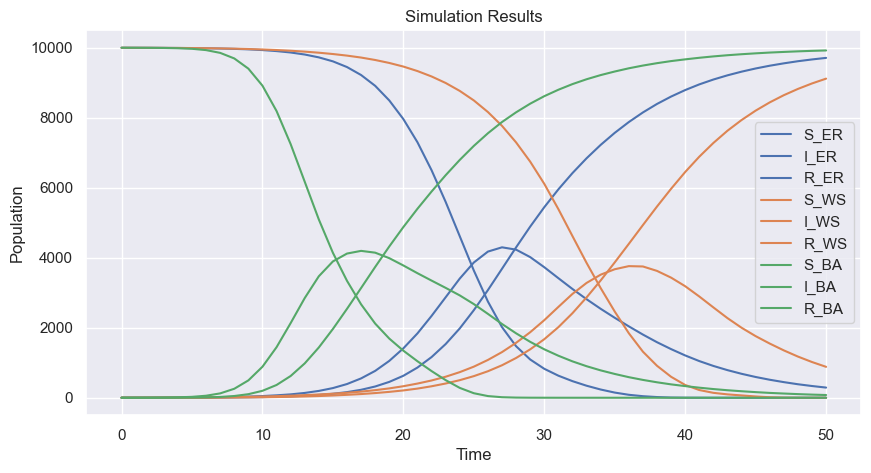

In [5]:
directory = "results/"
file_names = ["SIR_ER.csv", "SIR_WS.csv", "SIR_BA.csv"]

plt.figure(figsize=(10, 5))

# Iterate over the file names and process each simulation data file
for n, file_name in enumerate(file_names):
    path = directory + file_name

    # Process the simulation data
    simulation_df, spread_status_counts = processing_simulation_data(path)

    # Print the spread status counts and the proportion of True values
    print(f"File: {file_name}")
    print(spread_status_counts)
    print(spread_status_counts[True] / spread_status_counts.sum())
    print("-" * 20)

    # Filter the DataFrame to include only the rows where spread_status is True
    df = simulation_df.loc[True]
    time_step = df.index.get_level_values('time')[1] - df.index.get_level_values('time')[0]

    # Number of time points and index step for plotting
    dots = 100
    every = round((total_time+time_step)/(dots*time_step))

    # Unique columns and color for the plot
    columns = df.columns.get_level_values(1).unique()
    color = sns.color_palette()[n]

    # Plotting the mean values for each column
    for col in columns:
        label = f"{col}_{file_name.split('.')[0].split('_')[-1]}"
        sns.lineplot(data=df['mean'].iloc[::every, :], x='time', y=col, label=label, color=color)

# Show the plot
plt.title("Simulation Results")
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

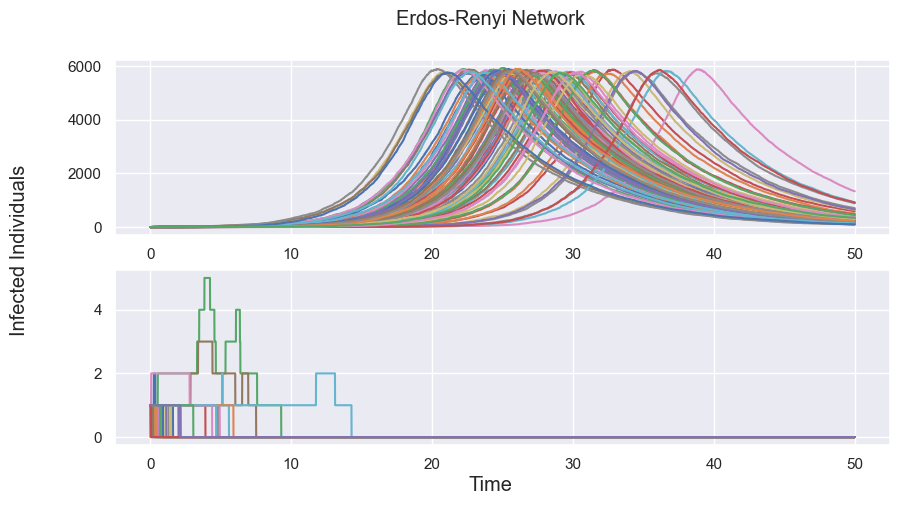

In [ ]:
# Read the data from the CSV file and sort it
raw_simulation_df = pd.read_csv("results/SIR_ER.csv", index_col=[0,1,2])
raw_simulation_df.sort_index(inplace=True)

# Create the figure
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

# For each spread status (True and False), plot the data
for n, boolean in enumerate([True, False]):
    # Filter the DataFrame to include only the rows where spread_status is True or False
    A = raw_simulation_df.loc[boolean]

    # Plot each simulation's data
    for sim in A.index.get_level_values('simulation').unique():
        axes[n].plot(A.loc[sim]['I'], label=sim if n == 0 else None)

# Show the plot
fig.suptitle("Erdos-Renyi Network")
fig.supxlabel('Time')
fig.supylabel("Infected Individuals")
plt.show()

## SEIIQHRDV Network Disease Spread Simulation

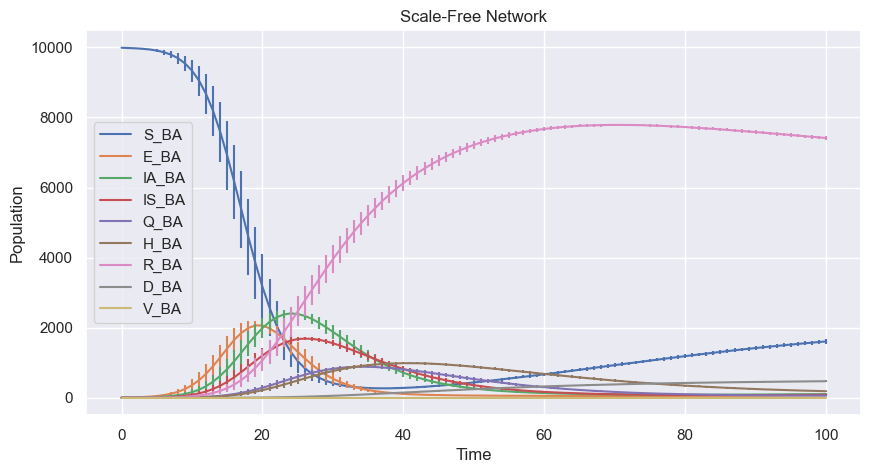

In [ ]:
# process the simulation data for the scale-free network
simulation_df, spread_status_counts = processing_simulation_data('results/SEIIQHRDV_BA.csv')
df = simulation_df.loc[True] # Filter for True spread status

# Find the time step and total time
time_step = df.index.get_level_values('time')[1] - df.index.get_level_values('time')[0]
total_time = df.index.get_level_values('time')[-1]

# Get the unique columns and colors for the plot
columns = df.columns.get_level_values(1).unique()
colors = sns.color_palette()[:len(columns)]

# Number of time points and index step for plotting
dots = 100
every = round((total_time+time_step)/(dots*time_step))

plt.figure(figsize=(10, 5))

# Plot the mean values for each column with error bars
for col, color in zip(columns, colors):
    label = f"{col}_{file_name.split('.')[0].split('_')[-1]}"
    sns.lineplot(data=df['mean'].iloc[::every, :], x='time', y=col, label=label, color=color)
    plt.errorbar(df['mean'].index[::every], df['mean'][col].iloc[::every], 
                yerr=df['std'][col].iloc[::every], linestyle='None', color=color)

# Show the plot
plt.title("Scale-Free Network")
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

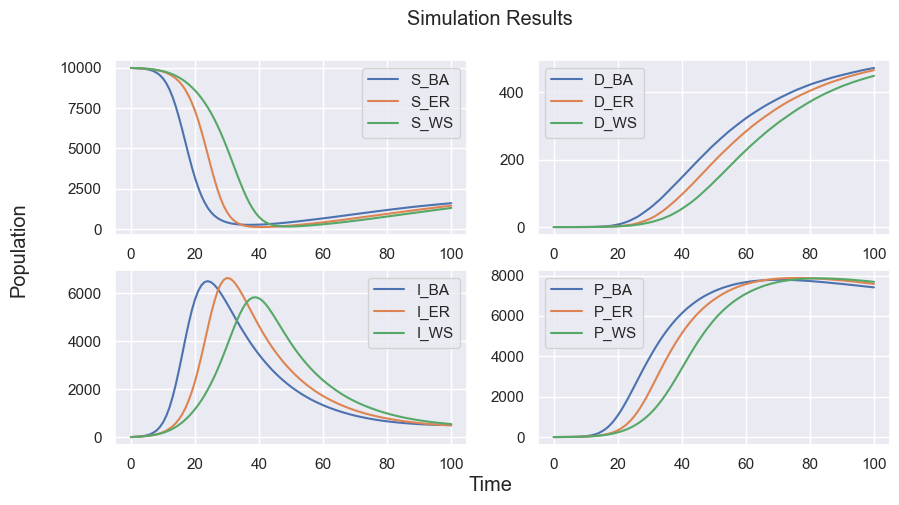

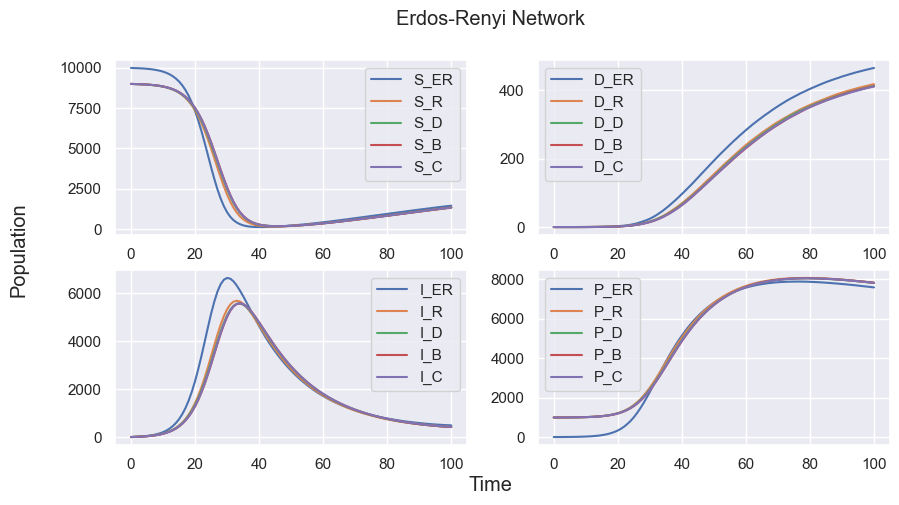

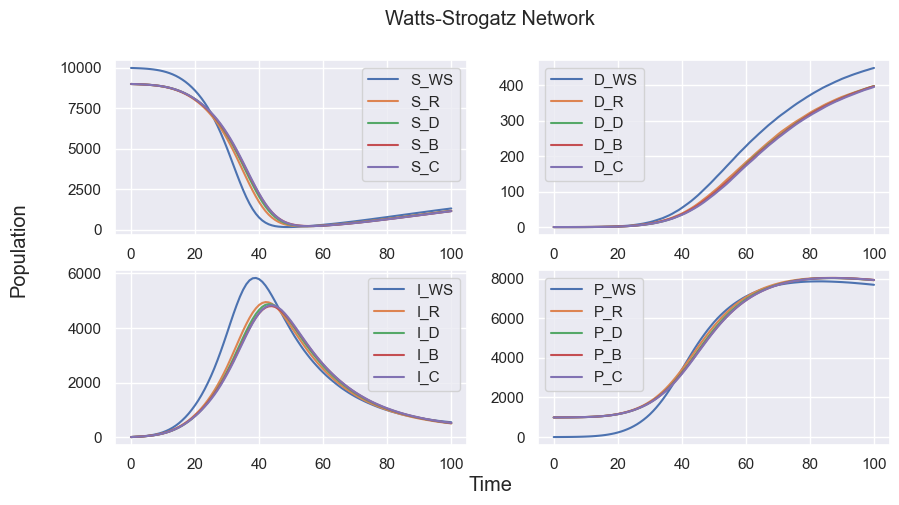

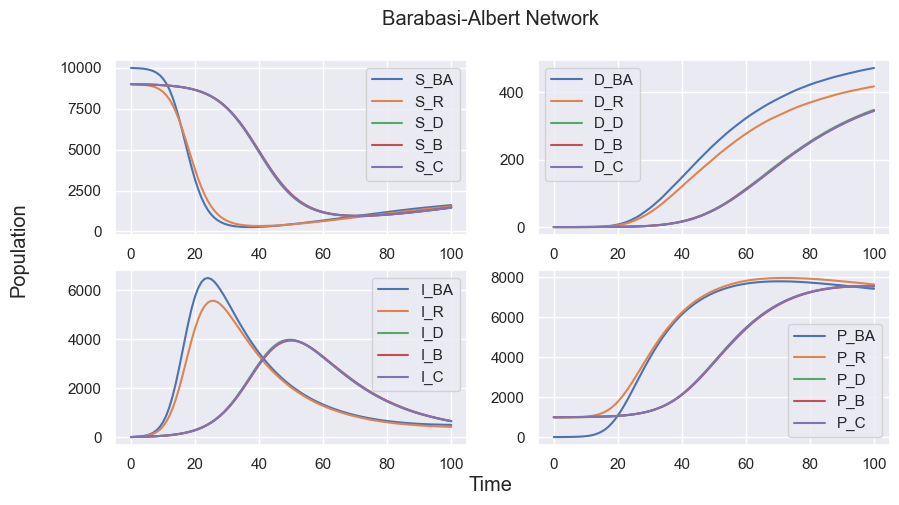

In [8]:
directory = "results/"
file_name_lists = [
    ["SEIIQHRDV_BA.csv", "SEIIQHRDV_ER.csv", "SEIIQHRDV_WS.csv"],
    ["SEIIQHRDV_ER.csv", "SEIIQHRDV_ER_R.csv", "SEIIQHRDV_ER_D.csv", "SEIIQHRDV_ER_B.csv", "SEIIQHRDV_ER_C.csv"],
    ["SEIIQHRDV_WS.csv", "SEIIQHRDV_WS_R.csv", "SEIIQHRDV_WS_D.csv", "SEIIQHRDV_WS_B.csv", "SEIIQHRDV_WS_C.csv"],
    ["SEIIQHRDV_BA.csv", "SEIIQHRDV_BA_R.csv", "SEIIQHRDV_BA_D.csv", "SEIIQHRDV_BA_B.csv", "SEIIQHRDV_BA_C.csv"]
]

plot_titles = [
    "Simulation Results",
    "Erdos-Renyi Network",
    "Watts-Strogatz Network",
    "Barabasi-Albert Network"
]

# Iterate over the file name lists
for file_name_list, plot_title in zip(file_name_lists, plot_titles):

    # Create the figure
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    
    # Iterate over the file names
    for n, file_name in enumerate(file_name_list):
        path = directory + file_name

        # Process the simulation data
        simulation_df, spread_status_counts = processing_simulation_data(path)
        df = simulation_df.loc[True]['mean'] # Filter for True spread status the 'mean' columns

        # Reorganize the DataFrame
        df["I"] = df["E"] + df["IA"] + df["IS"] + df["Q"] + df["H"]
        df["P"] = df["R"] + df["V"]
        df.drop(columns=["E", "IA", "IS", "Q", "H", "R", "V"], inplace=True)

        # Find the time step and total time
        time_step = df.index.get_level_values('time')[1] - df.index.get_level_values('time')[0]
        total_time = df.index.get_level_values('time')[-1]

        # Number of time points and index step for plotting
        dots = 100
        every = round((total_time+time_step)/(dots*time_step))
        colors = [sns.color_palette()[n]]*len(df.columns) # Same color for all columns

        # Plot the mean values for each column
        for i, (col, color) in enumerate(zip(df.columns, colors)):
            ax = axes[i//2, i%2]
            label = f"{col}_{file_name.split('.')[0].split('_')[-1]}"
            sns.lineplot(data=df.iloc[::every, :], x='time', y=col, label=label, color=color, ax=ax)
            ax.set_xlabel("")
            ax.set_ylabel("")

    # Show the plot
    fig.suptitle(plot_title)
    fig.supxlabel("Time")
    fig.supylabel("Population")
    plt.show()